## Introduction:

This dataset contains information about student study habits, exam performance, and overall knowledge level on the subject of electrical DC machines. The dataset was provided by undergraduate studnets at the Department of Electrical Education of Gazi University. Information on overall knowledge level was collected using an intuitive knowledge classifier. This project will explore the question of "what is a person's overall knowledge level of electrical DC machines based on their duration of study and number of repeated times studying?". The dataset used it the User Knowledge Modeling Data Set. This project will develop a method for classifying observations with unknown UNS values. UNS is a type of factor variable which classifies level of student understanding of electrical DC machines. Classification predictions will be made based on the STG and SCG columns, which are double floating point variables that contain observations for degree of study time for relevant materials and the degree of number of repetitions of relevant material during study respectively. 

In [5]:
suppressMessages(library(tidyverse))
suppressMessages(library(readxl))
suppressMessages(library(repr))
suppressMessages(library(tidymodels))

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”


In [6]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "knowledge_data.xls")

knowledge_train <- read_excel("knowledge_data.xls", sheet = 2, range = "A1:F259")
knowledge_test <- read_excel('knowledge_data.xls', sheet = 3, range = "A1:F146")
 
knowledge_train$UNS <- gsub('very_low', 'Very Low', knowledge_train$UNS)
knowledge_test$UNS <- gsub('very_low', 'Very Low', knowledge_test$UNS)

head(knowledge_train) 
head(knowledge_test)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


In [7]:
#finding total number of each class to check for over/underrepresentation
class_total <- group_by(knowledge_train, UNS) %>%
    summarize(n = n())
class_total

#checking for total missing values in relevant variables
is_na <- select(knowledge_train, STG, SCG) %>%
    summarize(STG_na_total = sum(is.na(STG)), SCG_na_total = sum(is.na(SCG)))
is_na

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<chr>,<int>
High,63
Low,83
Middle,88
Very Low,24


STG_na_total,SCG_na_total
<int>,<int>
0,0


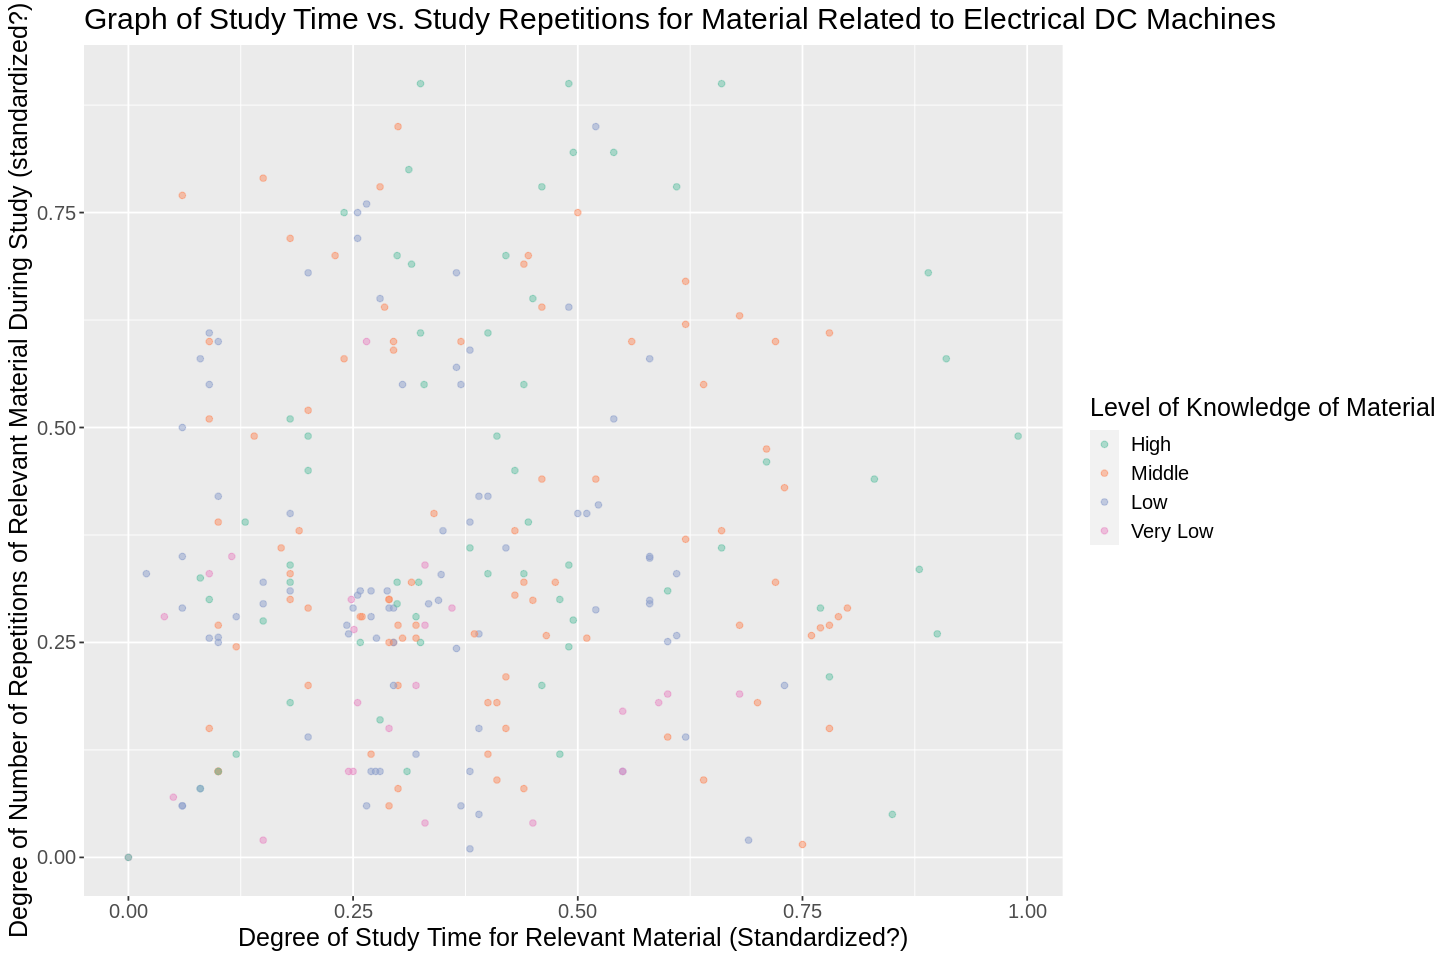

In [8]:
options(repr.plot.width = 12, repr.plot.height = 8) 
knowledge_train$UNS <- (factor(knowledge_train$UNS, levels = c('High', 'Middle', 'Low', 'Very Low'))) 
knowledge_plot <- ggplot(knowledge_train, aes(x = STG, y = SCG, color = UNS)) +
    geom_point(alpha = 0.5) + 
    labs(x = 'Degree of Study Time for Relevant Material (Standardized?)', y = 'Degree of Number of Repetitions of Relevant Material During Study (standardized?)', color = 'Level of Knowledge of Material') +
    ggtitle("Graph of Study Time vs. Study Repetitions for Material Related to Electrical DC Machines") +
    theme(text = element_text(size = 15)) +
    scale_color_brewer(palette = 'Set2') 
knowledge_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



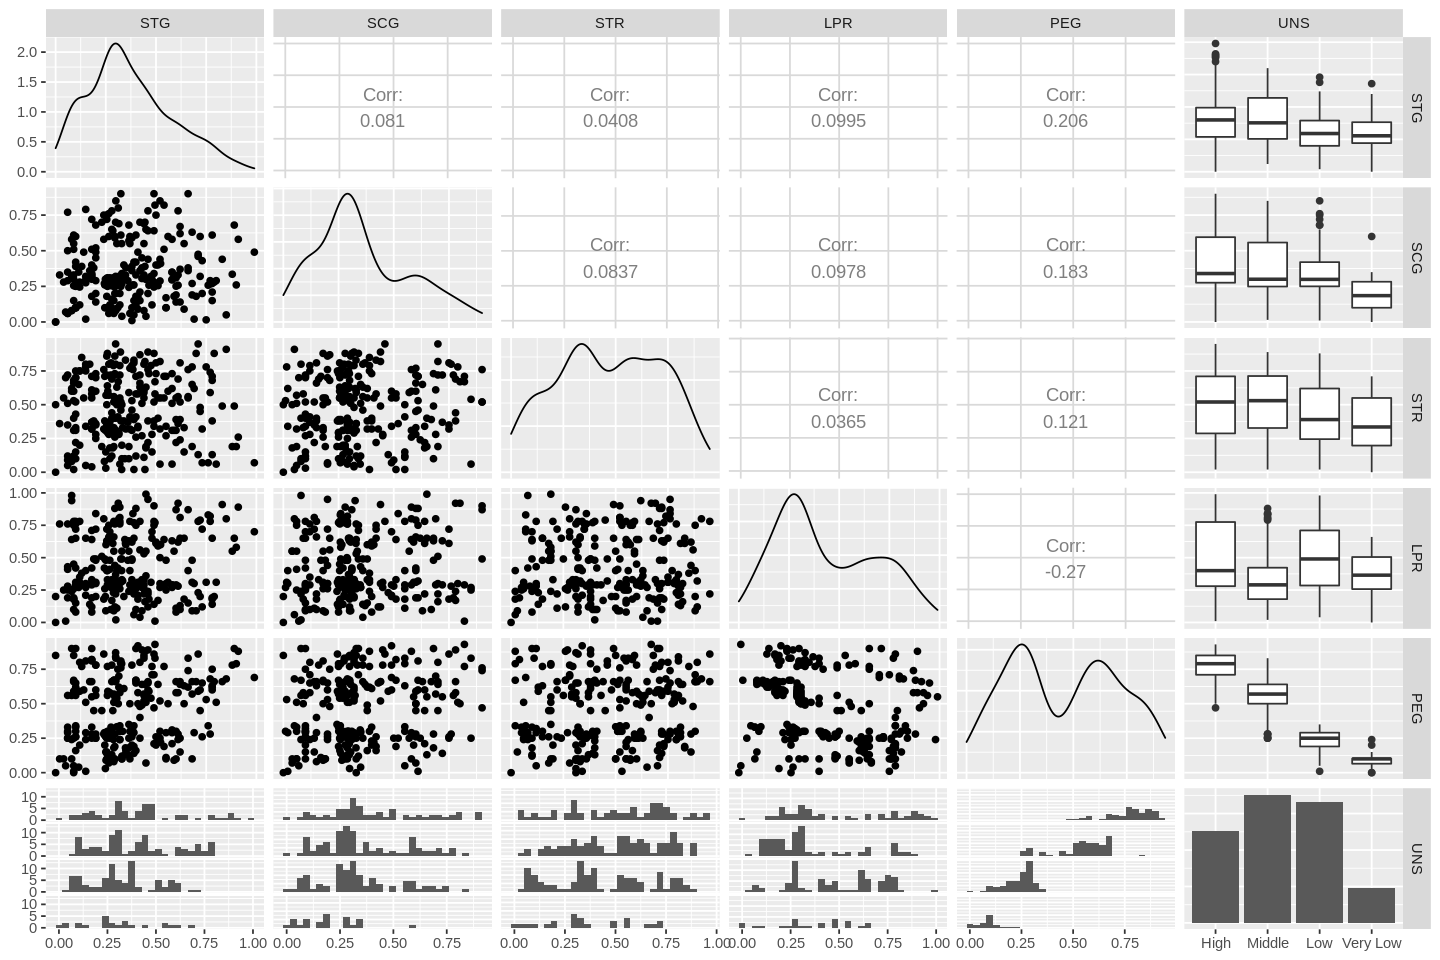

In [26]:
library(GGally)
knowledge_pairs <- knowledge_train %>% 
                    ggpairs()
knowledge_pairs

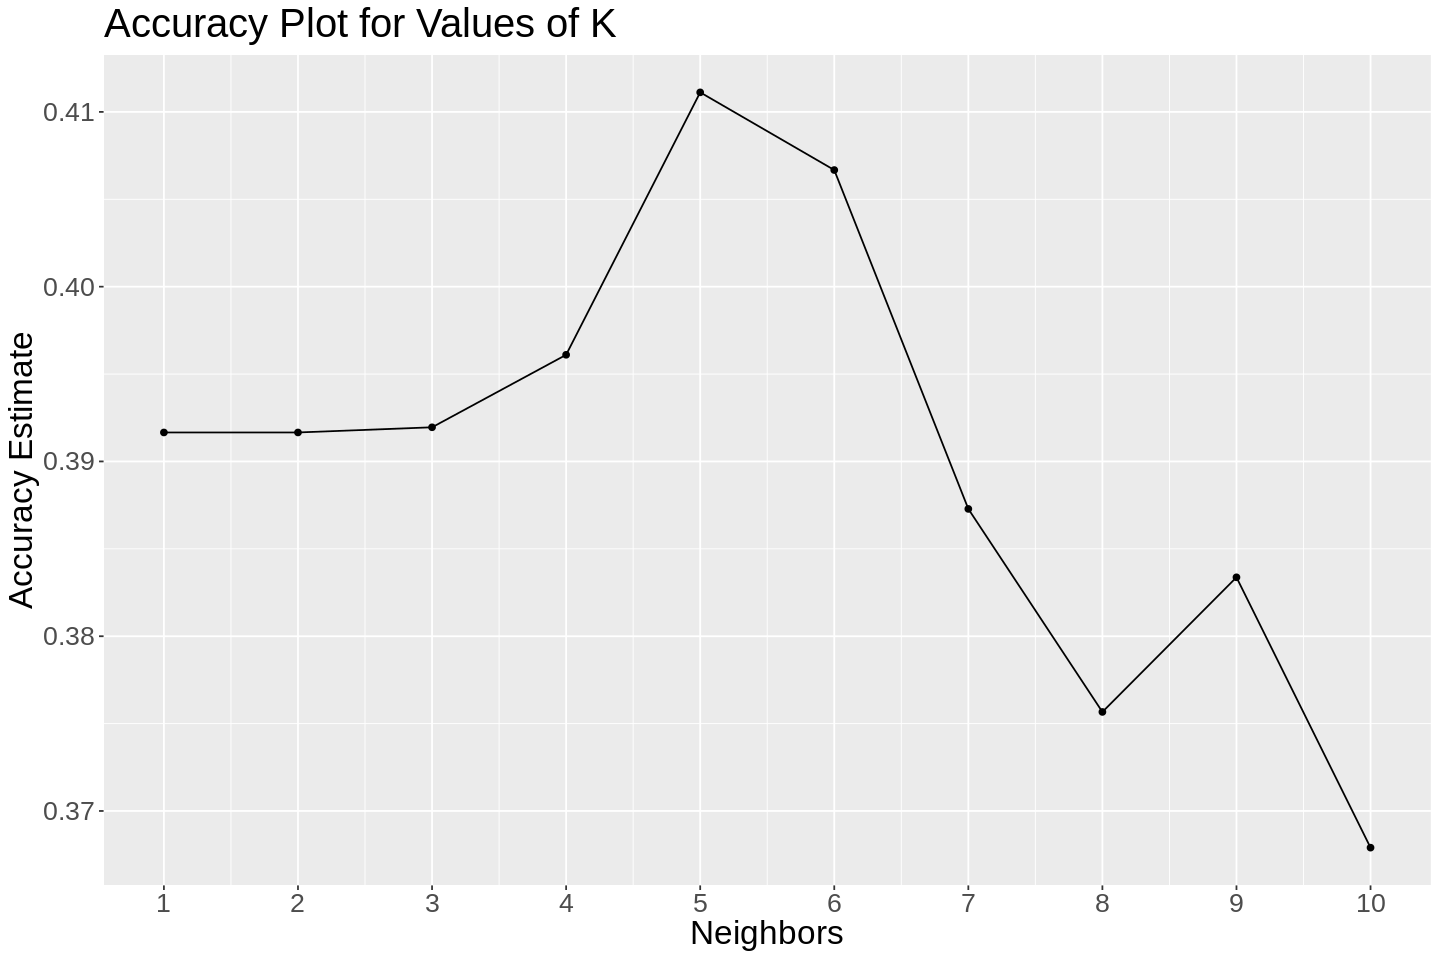

In [24]:
set.seed(2021) # Do not remove

knowledge_recipe <- recipe( UNS ~ PEG + STG, data = knowledge_train)


knowledge_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

gridvals <- tibble(neighbors = seq(1:10))


knowledge_vfold <- vfold_cv(knowledge_train, v = 5, strata = UNS)

knowledge_results <- workflow() %>%
                    add_recipe(knowledge_recipe) %>%
                    add_model(knowledge_tune) %>%
                    tune_grid(resamples = knowledge_vfold, grid = gridvals) %>%
                    collect_metrics() %>%
                    filter(.metric == "accuracy")
                    

knowledge_crossval_plot <- knowledge_results %>% 
                            ggplot(aes(x = neighbors, y = mean)) +
                            geom_point() + 
                            geom_line() +
                            labs(x = "Neighbors", y = "Accuracy Estimate") +
                            ggtitle("Accuracy Plot for Values of K") + 
                            scale_x_continuous(breaks = seq(1,10, by = 1)) + 
                            theme(text = element_text(size=20))

knowledge_crossval_plot

## Method

1. We will use Repr Tidyverse, and Tidymodels libraries.
2. Import file into the software. Clean and wrangle data. Legend is made uniform using Gsub function. Dataset is already split into training and testing sets with appropriate proportions.
3. Do summary statistics on training/testing data where applicable, and visualize the training data.
4. Split training data into C groups. Perform cross-validation to determine best fit for K.
5. Produce a visualization of K accuracy. Use the K-value with the most accurate prediction accuracy.
6. Prepare classification model (recipe, model, workflow, fit), and predict on testing data.
7. Collect metrics and do a confusion matrix on the prediction to assess accuracy.
8. Produce a visualization of results.
9. Create accuracy matrix.


## Expected Outcomes and Significance
This project expects to find the most optimal K-value through cross validation and a prediction of user knowledge score (UNS) using K-nearest neighbours classification with predictors study time (STG) and the number of repetitions on relevant materials (SCG). These findings will impact the specifications and the accuracy of our model and our model's capacity to predict user knowledge level respectively. Relevant questions emerging from this project may include how the findings can improve the effectiveness of study of electrical DC machines and the extent to which these findings can be applied to the study strategies of a broader group of subjects and students. In addition, further inquiries could pursue different predictors not in this data set to classify user knowledge of electrical DC machines, such as health habits and other study strategies that was not analyzed in the DC machine learning dataset. This could result in the finding of superior predictors for the classified variable.